<a href="https://colab.research.google.com/github/limshaocong/analyticsEdge/blob/main/Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries & Data Import Functions**

In [270]:
suppressMessages(library(tidyverse)) # generic must have package
library(dplyr)
library(ggplot2) # plotting package
library(lubridate) # easy comprehension of dates from string to correct datetime format
library(data.table)
library(purrr) # reduce
if("caret" %in% rownames(installed.packages()) == FALSE) {install.packages("caret")}
library(caret)
if("psych" %in% rownames(installed.packages()) == FALSE) {install.packages("psych")}
library(psych) # unscaling
if("padr" %in% rownames(installed.packages()) == FALSE) {install.packages("padr")}
library(padr)
if("janitor" %in% rownames(installed.packages()) == FALSE) {install.packages("janitor")}
library(janitor)

options(repr.plot.width = 9,
        repr.plot.height = 6,
        repr.plot.pointsize = 20)

Using the following functions to extract the daily trading data, twitter sentiment analysis, r/wsb sentiment analysis and news sentiment analysis. Thereafter, left-joining the data to daily trading data by ticker-date pairs to reduce the entire dataset down to trading days only.

In [386]:
git.path = "https://raw.githubusercontent.com/limshaocong/analyticsEdge/main/Datasets/"

# Prices
# Source: CRSP

price.path = "CRSP_WRDS/crsp_daily_stock_price_2020.csv"

get.prices <- function(tickerlist) {

  path = paste0(git.path, price.path)

  df = read.csv(path) %>%
    filter(ticker %in% tickerlist) %>%
    mutate(date = ymd(date)) %>%
    rename(low = BIDLO,
          high = ASKHI,
          open = OPENPRC,
          close = PRC,
          vol = VOL,
          Ntrades = NUMTRD) %>%
    select(ticker, date, open, close, high, low, vol) %>%
    mutate(change = close - open,
          dayspread = high - low)
}

# Twitter Sentiment Analysis
# Source: Open source
# Scrapped by snscrape
# Sentiment Analysis by BERT - zer0-shot, multilingual, sentiment model

twtr.path = "Imputed/twitter_sa.csv"

get.twitter.sa <- function (tickerlist){
  path = paste0(git.path, twtr.path)
  
  df = read.csv(path) %>%
    filter(ticker %in% tickerlist) %>%
    mutate(date = as.Date(date, format = "%m/%d/%y")) %>%
    rename(twtrmentions = mentions)
}

# r/wsb Sentiment Analysis
# Source: Quiver Quant
# Sentiment based on VADER sentiment

wsb.path = "Imputed/wsb_imputed_min0.csv"

get.wsb.sa <- function(tickerlist){

  path = paste0(git.path, wsb.path)

  df = read.csv(path) %>%
    filter(Ticker %in% tickerlist) %>%
    mutate(date = ymd(Date)) %>%
    pad(start_val = as.Date('2020-01-01'), end_val = as.Date('2020-12-31')) %>%
    select(Ticker, Date, Mentions, log10Mentions, Sentiment) %>%
    rename(wsbsentiment = Sentiment,
          wsbmentions = Mentions,
          wsblog10mentions = log10Mentions) %>%
    rename_with(tolower)
}

# News Sentiment - Dow Jones + Global Press

pr.path = "Imputed/rp_imputed_min500.csv"

get.news.sa <- function(tickerlist){

  path = paste0(git.path, pr.path)

  df = read.csv(path) %>%
    filter(Date >= as.Date("2020-01-01") & Date <= as.Date("2020-12-31")) %>%
    filter(ticker %in% tickerlist) %>%
    mutate(date = ymd(Date)) %>%
    rowwise() %>%
    mutate(newssentiment = mean(DJ_mean_ess * DJ_news_instance, PR_mean_ess * PR_news_instance)/All_news_instance) %>%
    replace(is.na(.), 0) %>%
    mutate(newssentiment = (newssentiment-50)/100) %>%
    select(ticker, Date, All_news_instance, newssentiment, log10Allmentions) %>%
    rename(newsmentions = All_news_instance,
          newslog10mentions = log10Allmentions) %>%
    rename_with(tolower)
}

# Compile all data
# Left join to prices df retaining only trading days

get.all.data <- function(tickerlist) {

  prices = get.prices(tickerlist)
  prices$date = as.Date(prices$date)

  wsb.sa = get.wsb.sa(tickerlist)
  wsb.sa$date = as.Date(wsb.sa$date)

  news.sa = get.news.sa(tickerlist)
  news.sa$date = as.Date(news.sa$date)

  twitter.sa = get.twitter.sa(tickerlist)
  twitter.sa$date = as.Date(twitter.sa$date)

  df = list(prices, wsb.sa, news.sa, twitter.sa) %>%
            reduce(left_join, by = c("ticker", "date"))
}

check.missing.data <- function(df) {
  complete.row = sum(complete.cases(df))
  actual.row = dim(df)[1]

  if(complete.row == actual.row) {
    print("No missing data")
  } else {
    print("Missing data present")
  }
}

In [466]:
tickerlist = list("TSLA", "AAPL")

imported_df = get.all.data(tickerlist) %>%
  arrange(ticker, date)

ticker.count = length(unique(imported_df[["ticker"]]))

check.missing.data(imported_df)

pad applied on the interval: day



[1] "No missing data"


# **(Slight) Feature Engineering**

In [467]:
# Add in target variable

df = imported_df %>%
  group_by(ticker) %>%
  mutate(target = lead(close, n = 1, default = NA)) %>% # target using by taking the $close of the next period
  mutate(prevclose1 = lag(close, n = 1, default = NA), # additional variables by lagging earlier $close
         prevclose2 = lag(close, n = 2, default = NA), # in log2 scale, kaggle trick
         prevclose4 = lag(close, n = 4, default = NA),
         prevclose8 = lag(close, n = 8, default = NA)) %>%
  mutate(prevwsbsentiment1 = lag(wsbsentiment, n = 1, default = NA), # additional variables by lagging earlier $wsbsentiment
         prevwsbsentiment2 = lag(wsbsentiment, n = 2, default = NA), # in log2 scale, kaggle trick
         prevwsbsentiment4 = lag(wsbsentiment, n = 4, default = NA),
         prevwsbsentiment8 = lag(wsbsentiment, n = 8, default = NA)) %>%
  mutate(prevnewssentiment1 = lag(newssentiment, n = 1, default = NA), # additional variables by lagging earlier $newssentiment
         prevnewssentiment2 = lag(newssentiment, n = 2, default = NA), # in log2 scale, kaggle trick
         prevnewssentiment4 = lag(newssentiment, n = 4, default = NA),
         prevnewssentiment8 = lag(newssentiment, n = 8, default = NA)) %>%
  mutate(prevtwtrsentiment1 = lag(twtrsentiment, n = 1, default = NA), # additional variables by lagging earlier $twtrsentiment
         prevtwtrsentiment2 = lag(twtrsentiment, n = 2, default = NA), # in log2 scale, kaggle trick
         prevtwtrsentiment4 = lag(twtrsentiment, n = 4, default = NA),
         prevtwtrsentiment8 = lag(twtrsentiment, n = 8, default = NA)) %>%
  na.omit %>%
  as.data.frame()

In [468]:
# Do scaling of all variables
# Retain means and sd for unscaling of data

scaling.mean = colMeans(df[sapply(df, is.numeric)])
scaling.sd = sapply(df[sapply(df, is.numeric)], sd)

df[map_lgl(df, is.numeric)] = df %>%
                              select(is.numeric) %>%
                              scale(center = scaling.mean, scale = scaling.sd)

In [469]:
# One-hot encoding for ticker

if (ticker.count > 1){
  dummy = dummyVars(" ~ .", data = df)
  df = data.frame(predict(dummy, newdata = df))
} 

Final check for missing data before model training

In [471]:
check.missing.data(df)

[1] "No missing data"


# **Train-Validate-Test Split**



In [472]:
split = unclass(as.Date("2020-09-30"))

# Train-test split
train = df %>% filter(date <= split)
test = df %>% filter(date > split)

train.days = dim(train)[1]/ticker.count
test.days = dim(test)[1]/ticker.count

train.prop = train.days/(train.days + test.days)

print("% of Training Data")
print(train.prop)
print(train.days)

[1] "% of Training Data"
[1] 0.7418033
[1] 181


This splitting of train-validate only serves as an illustration. The real splitting is embedded in the training process as per normal CV. However, as normal k-fold CV does not work on time series data due to the emphasis its temporal features, a sliding window approach is used (see Section 4.3 of https://topepo.github.io/caret/data-splitting.html#time)

In [473]:
# In this instance, with 181 days worh of data, there are 22 folds based on the chosen parameters

index = 1:train.days
folds = createTimeSlices(index, initialWindow = 120, horizon = 40, fixedWindow = TRUE)
lapply(folds, length)

$train
[1] 22

$test
[1] 22

Sample of how the folds are constructed is as follows.

In [474]:
print("Training fold 1")
print(folds$train$Training120)

print("Validation fold 1")
print(folds$test$Testing120)

[1] "Training fold 1"
  [1]   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
 [19]  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
 [37]  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
 [55]  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
 [73]  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
 [91]  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
[109] 109 110 111 112 113 114 115 116 117 118 119 120
[1] "Validation fold 1"
 [1] 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139
[20] 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158
[39] 159 160


# **Model Building and Selection**

In [475]:
library(rpart)
if("rpart.plot" %in% rownames(installed.packages()) == FALSE) {install.packages("rpart.plot")}
library(rpart.plot)
if("Metrics" %in% rownames(installed.packages()) == FALSE) {install.packages("Metrics")}
library(Metrics)

In [476]:
# Takes a vector input and returns unscaled predictions
# Both the original target and 

unscale_Y <- function(vec){
  unscaled = vec * scaling.sd[["target"]] + scaling.mean[["target"]] 
}

## **Naive Model - Random Walk**

In [477]:
rw.df = test
rw.df$pred = rw.df$close

mape(unscale_Y(rw.df$target), unscale_Y(rw.df$pred))

[1] 0.02262463

##**CART**

In [478]:
train.control = trainControl(method = "timeslice",
                            initialWindow = 120,
                            horizon = 40,
                            fixedWindow = TRUE)

cpVals = data.frame(.cp = seq(0.00000000001, 0.0000000003, by = 0.00000000001))

mod = train(target ~ . - date,
            data = train,
            method = "rpart",
            trControl = train.control,
            tuneGrid = cpVals)

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


In [407]:
mod$modelType
mod$bestTune

[1] "Regression"

,cp
,<dbl>
30,3e-10


In [479]:
train$pred = predict(object = mod$finalModel, newdata = train)
test$pred = predict(object = mod$finalModel, newdata = test)

In [482]:
train.pred = unscale_Y(train$pred)
train.target = unscale_Y(train$target)

test.pred = unscale_Y(test$pred)
test.target = unscale_Y(test$target)

print("train")
print(mape(train.target, train.pred))
print("test")
print(mape(test.target, test.pred))

[1] "train"
[1] 0.04383136
[1] "test"
[1] 0.05404993


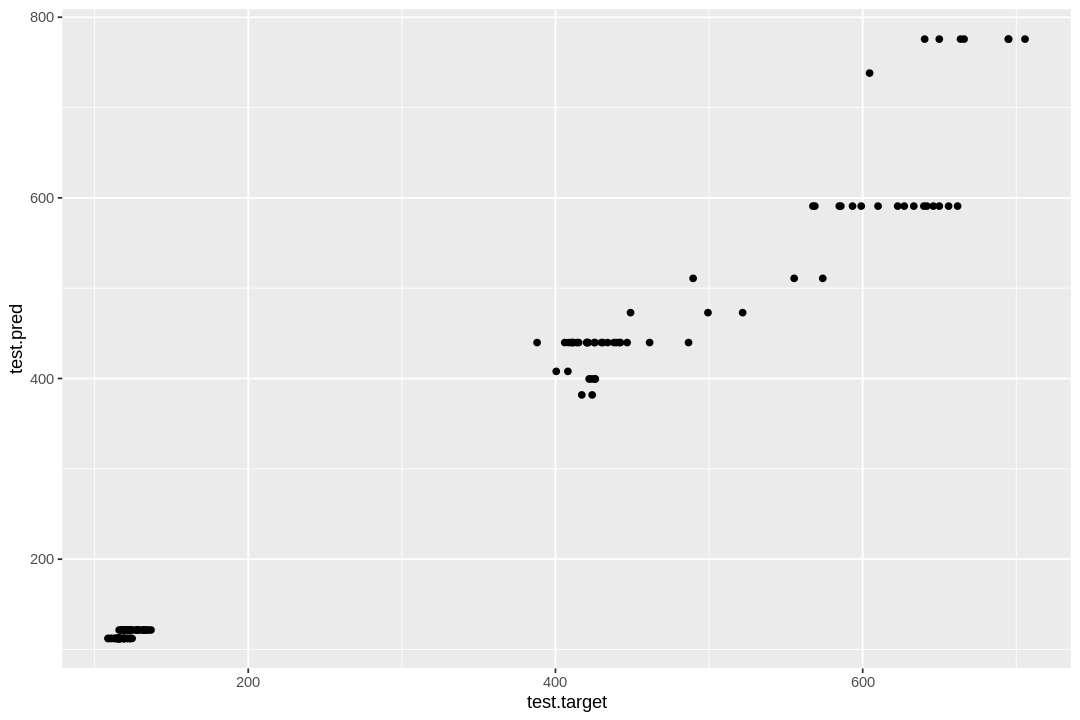

In [481]:
ggplot() +
geom_point(aes(x = test.target, y = test.pred))